In [1]:
import trident
import numpy as np
import yt
import MISTY
import sys
import os

import matplotlib as mpl
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
mpl.rcParams['font.family'] = 'stixgeneral'
#mpl.rcParams['font.size'] = 6.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

from astropy.table import Table
from astropy.io import fits
from astropy.convolution import Gaussian1DKernel, convolve

from get_proper_box_size import get_proper_box_size
from get_refine_box import get_refine_box
from get_halo_center import get_halo_center
from consistency import *


/Users/molly/anaconda2/envs/astroconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
consistency.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/molly/anaconda2/envs/astroconda/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/molly/anaconda2/envs/astroconda/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/molly/anaconda2/envs/astroconda/lib/pyt

In [2]:
def read_spectrum(ds, fits_name):
    print "opening ", fits_name
    hdulist = fits.open(fits_name)
    ray_start_str, ray_end_str = hdulist[0].header['RAYSTART'], hdulist[0].header['RAYEND']
    ray_start = [float(ray_start_str.split(",")[0].strip('unitary')), \
           float(ray_start_str.split(",")[1].strip('unitary')), \
           float(ray_start_str.split(",")[2].strip('unitary'))]
    ray_end = [float(ray_end_str.split(",")[0].strip('unitary')), \
           float(ray_end_str.split(",")[1].strip('unitary')), \
           float(ray_end_str.split(",")[2].strip('unitary'))]
    rs, re = np.array(ray_start), np.array(ray_end)
    rs = ds.arr(rs, "code_length")
    re = ds.arr(re, "code_length")
    ray = ds.ray(rs, re)

    return hdulist, ray_start, ray_end, ray, hdulist[0].header['IMPACT']


In [3]:
ds = yt.load("/Users/molly/foggie/halo_008508/nref11n/nref11n_nref10f_refine200kpc/RD0020/RD0020")
output_dir = "/Users/molly/Dropbox/foggie-collab/plots_halo_008508/nref11n/nref11n_nref10f_refine200kpc/spectra/"
# ds = yt.load("/Users/molly/foggie/halo_008508/nref11n/natural/RD0020/RD0020")
track_name = "/Users/molly/foggie/halo_008508/nref11n/nref11n_nref10f_refine200kpc/halo_track"


yt : [INFO     ] 2018-06-03 12:20:09,615 Parameters: current_time              = 154.801032717
yt : [INFO     ] 2018-06-03 12:20:09,617 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2018-06-03 12:20:09,618 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2018-06-03 12:20:09,620 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2018-06-03 12:20:09,622 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2018-06-03 12:20:09,623 Parameters: current_redshift          = 1.99999968795
yt : [INFO     ] 2018-06-03 12:20:09,624 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2018-06-03 12:20:09,625 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2018-06-03 12:20:09,627 Parameters: hubble_constant           = 0.695


In [4]:
track = Table.read(track_name, format='ascii')
track.sort('col1')
zsnap = ds.get_parameter('CosmologyCurrentRedshift')
proper_box_size = get_proper_box_size(ds)
refine_box, refine_box_center, x_width = get_refine_box(ds, zsnap, track)
halo_center, v = get_halo_center(ds, refine_box_center)
x_left = np.float(refine_box.left_edge[0].value)
x_right = np.float(refine_box.right_edge[0].value)
y_left = np.float(refine_box.left_edge[1].value)
y_right = np.float(refine_box.right_edge[1].value)


Parsing Hierarchy : 100%|██████████| 4574/4574 [00:00<00:00, 27718.21it/s]

('using this loc:', <Table length=1>
   col1     col2     col3     col4     col5     col6     col7    col8
 float64  float64  float64  float64  float64  float64  float64  int64
--------- -------- -------- -------- -------- -------- -------- -----
2.0499999 0.493091 0.488119 0.501099 0.495091 0.490119 0.503099    10)



yt : [INFO     ] 2018-06-03 12:20:42,234 Gathering a field list (this may take a moment.)


We have located the main halo at : [0.4940309524536133, 0.48897266387939453, 0.5021486282348633]


In [5]:
fits_name = '/Users/molly/Dropbox/foggie-collab/plots_halo_008508/nref11n/nref11n_nref10f_refine200kpc/spectra/hlsp_misty_foggie_halo008508_nref11n_nref10f_rd0020_axz_i016.6-a5.84_v5_los.fits.gz'
fits_name_base = 'hlsp_misty_foggie_halo008508_nref11n_nref10f_rd0020_axz_i016.6-a5.84_v5_los'
hdulist, ray_start, ray_end, ray, impact = read_spectrum(ds, fits_name)
ray_sort = np.argsort(ray['t'])
ray_min = np.min(ray['x'][ray_sort])
ray_max = np.max(ray['x'][ray_sort])
print "~~~~~~~~~~~~~~THIS IS THE ORIGINAL RAY START AND END:", ray_start, ray_end
full_ray_end = ray_end


opening  /Users/molly/Dropbox/foggie-collab/plots_halo_008508/nref11n/nref11n_nref10f_refine200kpc/spectra/hlsp_misty_foggie_halo008508_nref11n_nref10f_rd0020_axz_i016.6-a5.84_v5_los.fits.gz
~~~~~~~~~~~~~~THIS IS THE ORIGINAL RAY START AND END: [0.493091, 0.4889080272297428, 0.5024884884554948] [0.495091, 0.4889080272297428, 0.5024884884554948]


yt : [INFO     ] 2018-06-03 12:26:45,357 xlim = 0.493091 0.495091
yt : [INFO     ] 2018-06-03 12:26:45,359 ylim = 0.488119 0.490119
yt : [INFO     ] 2018-06-03 12:26:45,361 xlim = 0.493091 0.495091
yt : [INFO     ] 2018-06-03 12:26:45,363 ylim = 0.488119 0.490119
yt : [INFO     ] 2018-06-03 12:26:45,365 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 800 by 800



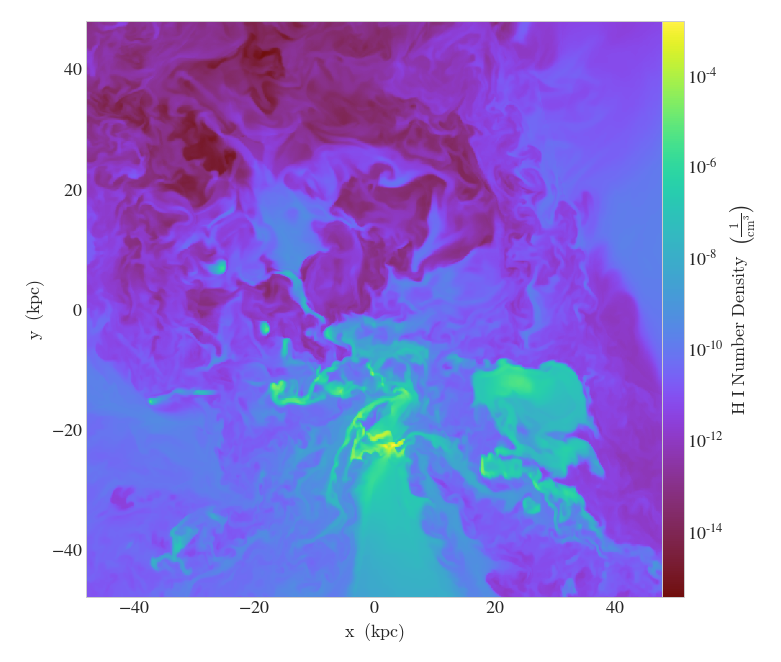

In [11]:
z_center = [refine_box_center[0], refine_box_center[1], ray_start[2]]
slc = yt.SlicePlot(ds, 'z', ('gas','H_p0_number_density'), center=z_center, width=x_width)
slc.show()


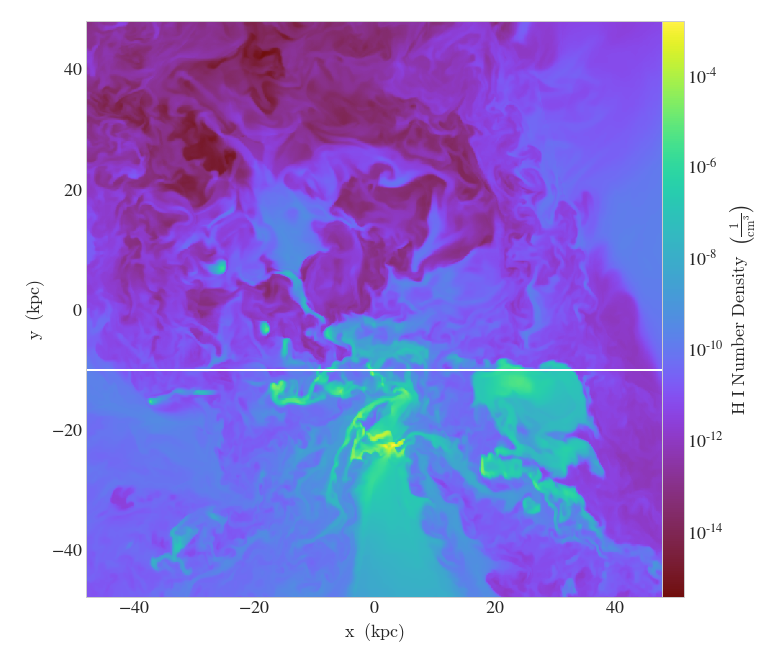

In [12]:
slc.annotate_line(ray_start, ray_end)

0.493091 0.495091 0.488119 0.490119


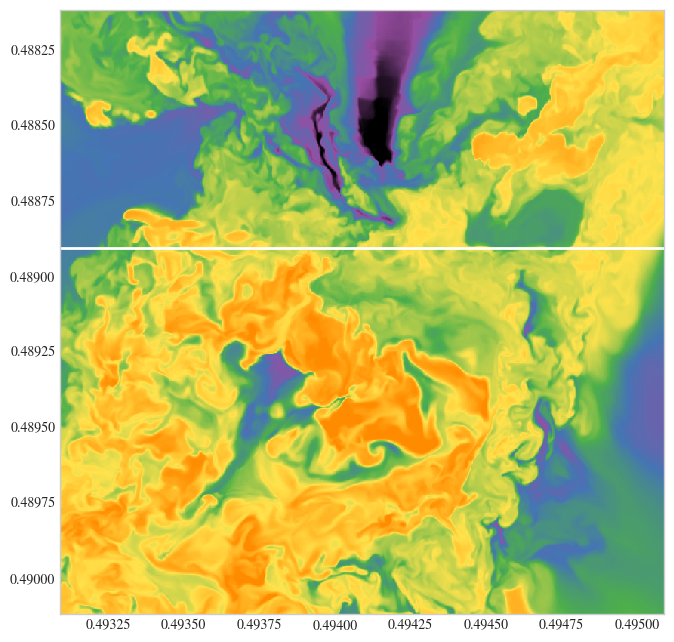

In [23]:
print x_left, x_right, y_left, y_right
res = [1000,1000]
frb = slc.frb['gas','metallicity']
image = np.array(frb)
## print "min, max metallicity = ", np.min(np.log10(image)), np.max(np.log10(image))
extent = [x_left, x_right, y_right, y_left]
fig = plt.figure(figsize=(8,8), dpi=100)

## this will be the slice
ax_slice = fig.add_subplot(111)
frb_slc = ax_slice.imshow(np.log10(image), extent=extent, cmap=metal_color_map, \
                                vmin=np.log10(metal_min), vmax=np.log10(metal_max))
ax_slice.plot([ray_start[0], ray_end[0]], [ray_start[1], ray_end[1]], color="white", lw=2.)
        